In [2]:
#libraries
import warnings
warnings.filterwarnings('ignore')

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error
from collections import Counter
from time import time

In [4]:
#load dataset
df = pd.read_csv('data/train_V2.csv')
test_df = pd.read_csv('data/test_V2.csv')
sample_submission = pd.read_csv('data/sample_submission_V2.csv')

In [5]:
sample_submission.head()

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1


# functions

In [575]:
#timer
def timer(func):
    start = time()
    func()
    print(time()-start)

#utility function - closest from list:
def get_closest_from_list(num,list_):
    try:
        return min(list_, key=lambda x:abs(x-num))
    except:
        return num

#histogram
def histogram(stats,max_size,min_threshold=0,min_threshold_var=None):
    fig, ax = pyplot.subplots(figsize=(16,8))
    df_temp = df
    if min_threshold_var != None:
        df_temp = df_temp[df_temp[min_threshold_var] > min_threshold]
    else:
        for stat in stats:
            df_temp = df_temp.loc[(df_temp[stat]>=min_threshold)]
    for stat in stats:
        df_temp = df_temp[(df_temp[stat]<max_size)]
    [sns.distplot(df_temp[stat],ax=ax,kde=False,bins=max_size) for stat in stats]
    
#game size
def get_match_size(match_id):
    pass
    #get size of df given match id

def get_average_group_size():
    pass

# custom loss function
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain #.get_labels() #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

# data exploration and visualization

In [8]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [9]:
exogenous_vars = {
    'combat':['kills','assists','heals','DBNOs','weaponsAcquired','vehicleDestroys'],
    'kill_stats':['headshotKills','killStreaks','roadKills'],
    'distance_metrics':['walkDistance','rideDistance','swimDistance'],
    'game_data':['numGroups','matchDuration','matchType'],
}

In [10]:
#number rows
df.shape[0]

4446966

In [11]:
#number of matches
df.matchId.unique().shape[0]

47965

In [12]:
df.fillna(0,inplace=True)

In [13]:
the_stats = 

SyntaxError: invalid syntax (<ipython-input-13-264b8f2ff64f>, line 1)

In [ ]:
histogram(['kills','assists','heals','DBNOs','boosts'],25)

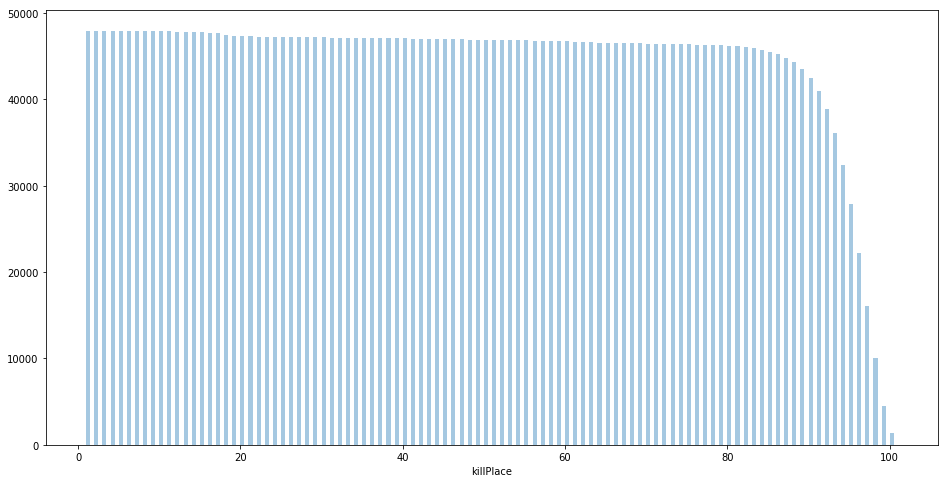

In [14]:
histogram(['killPlace'],200)

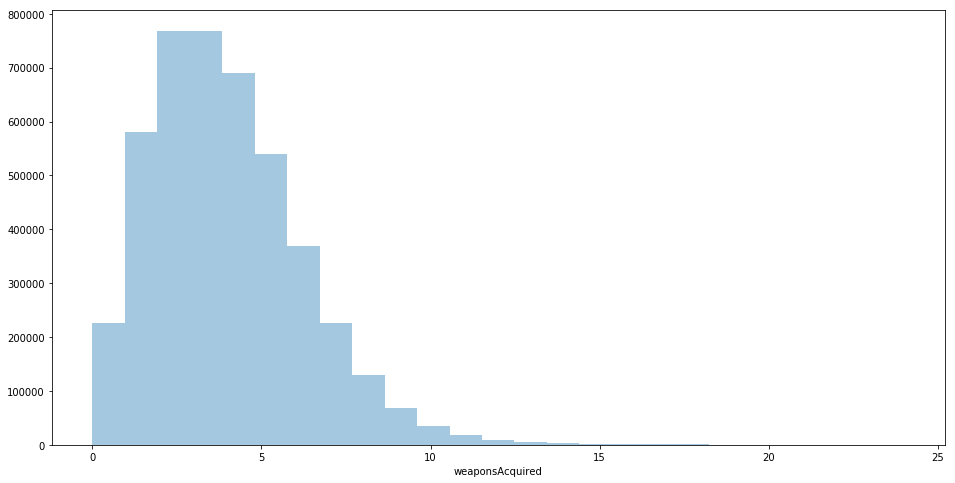

In [15]:
histogram(['weaponsAcquired'],25)

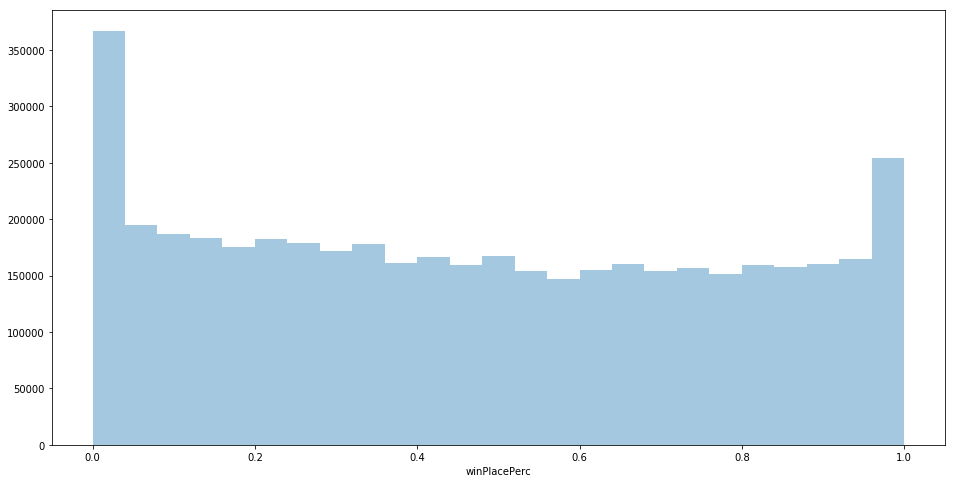

In [16]:
histogram(['winPlacePerc'],25)

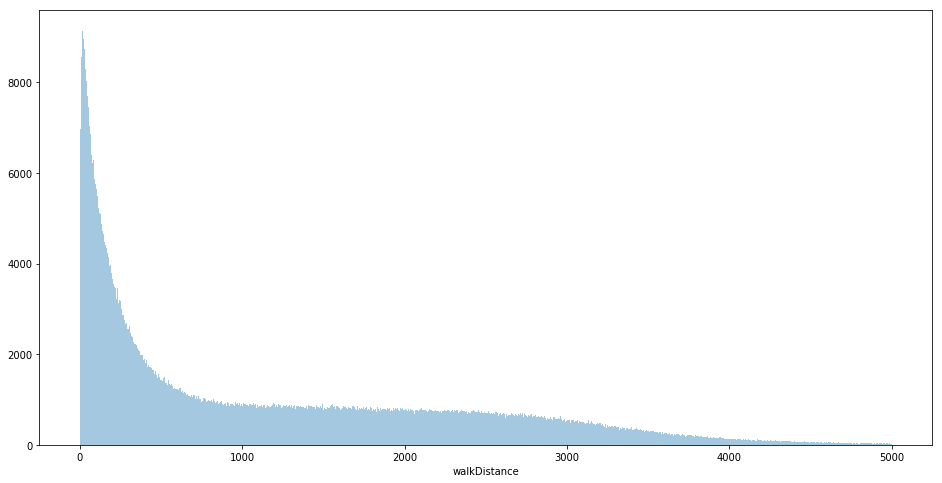

In [17]:
histogram(['walkDistance'],5000,min_threshold=1)

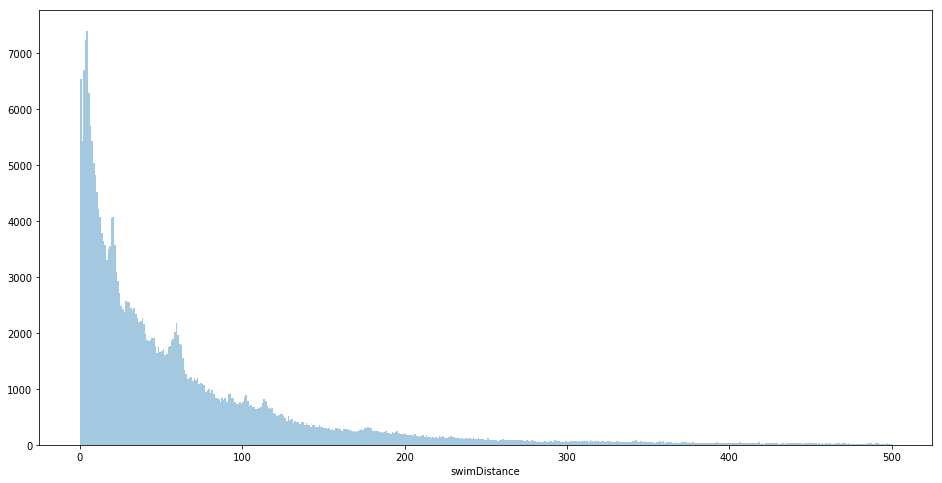

In [19]:
histogram(['swimDistance'],500,min_threshold=0.0001)

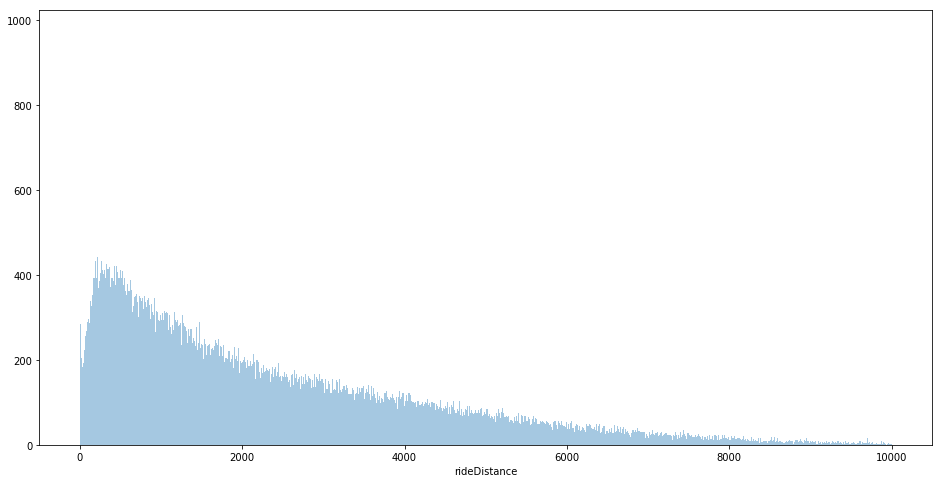

In [20]:
histogram(['rideDistance'],10000,min_threshold=1)

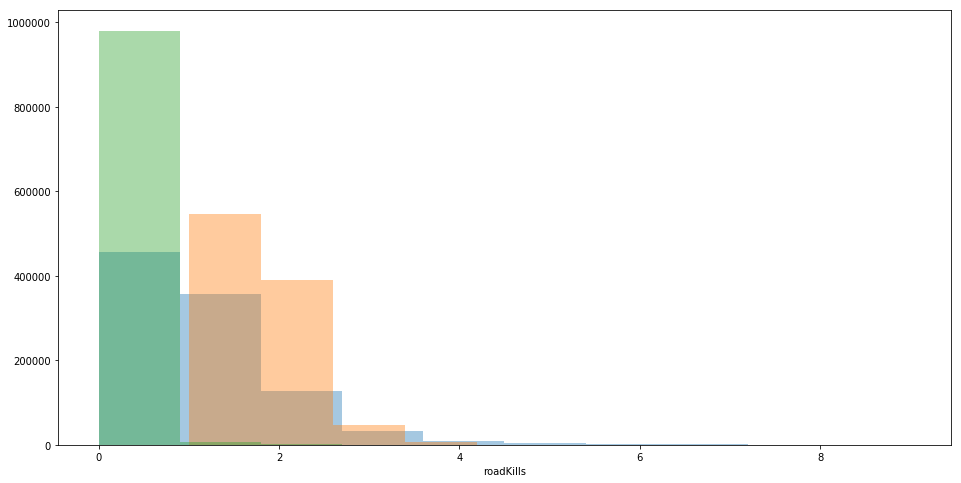

In [21]:
histogram(df[exogenous_vars['kill_stats']],10,min_threshold=1,min_threshold_var='kills')

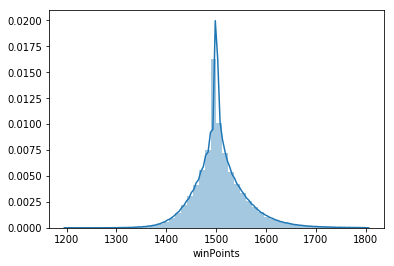

In [22]:
sns.distplot(df.loc[(df.winPoints > 1200) & (df.winPoints < 1800)]['winPoints'])

# Normalize Stats for Game Size

In [23]:
#column-wise with counter
start = time()
player_count = Counter(df['matchId'])
df['num_players'] = df['matchId'].apply(lambda mid: player_count[mid])
print(time()-start)

2.5622589588165283


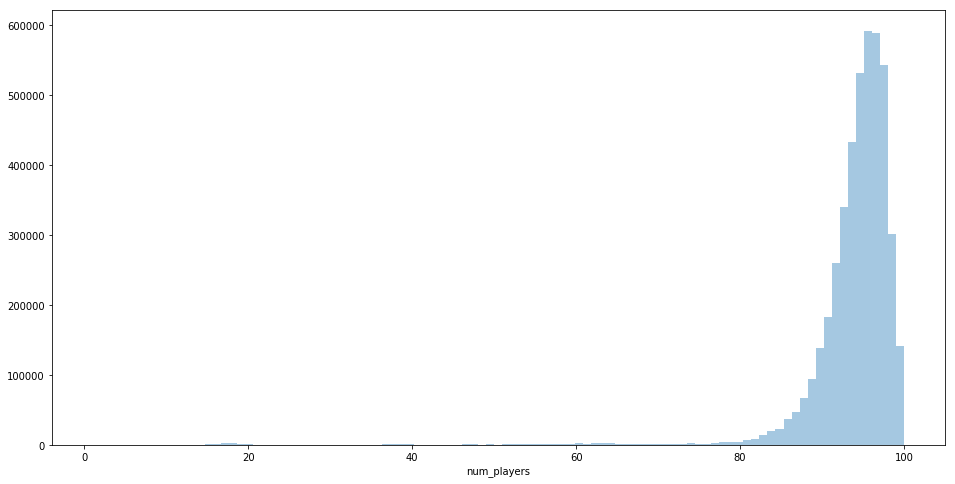

In [24]:
histogram(['num_players'],101)

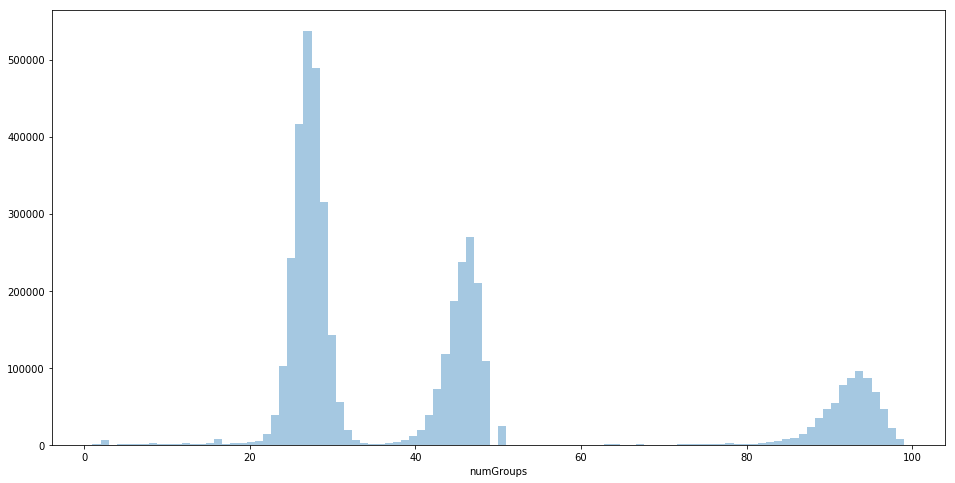

In [25]:
histogram(['numGroups'],100)

# Number of Players

In [26]:
df['num_players'] = df['matchId'].apply(lambda mid: player_count[mid])

In [27]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,num_players
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


In [28]:
df['groupId'].nunique()/df['matchId'].nunique()

42.2546648597936

In [29]:
#groups
start = time()
group_count = Counter(df['groupId'])
df['group_size'] = df['groupId'].apply(lambda gid: group_count[gid])
print(time()-start)

4.974424123764038


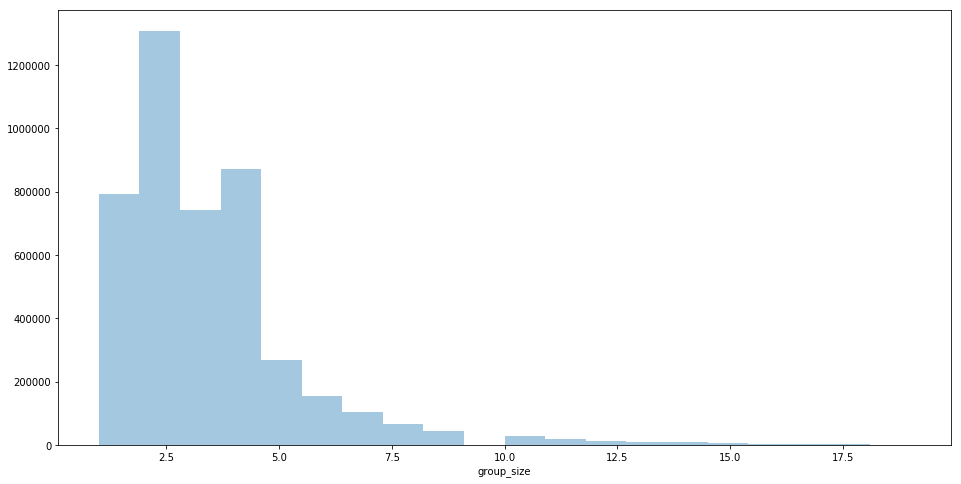

In [30]:
histogram(['group_size'],20)

In [31]:
#df[df.group_size==1][['group_size','numGroups','test_test']]

In [32]:
df.matchType.unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

# Discrete Values

Predetermined possible values for winPlacePerc come from number of groups in match

In [33]:
df[['numGroups','num_players','maxPlace','winPlacePerc']].head()

,numGroups,num_players,maxPlace,winPlacePerc
0,26,96,28,0.4444
1,25,91,26,0.6400
2,47,98,50,0.7755
3,30,91,31,0.1667
4,95,97,97,0.1875


### Define new column that has lists of discrete values

In [34]:
possible_outcomes_dict = {}
possible_outcomes_dict[1] = [np.float(0)]
for i in range(2,101):
    possible_outcomes_dict[i] = [np.float(round(j/(i-1),4)) for j in range(0,i)]

In [35]:
df['possible_winPlacePerc'] = df['maxPlace'].apply(lambda num_of_groups: possible_outcomes_dict[num_of_groups])

#### validate

In [36]:
def my_test(row):
    return row['winPlacePerc'] in row['possible_winPlacePerc']

df['test_test'] = df.apply(my_test, axis=1)

In [37]:
np.mean(df['test_test'])

0.9971022940134915

# First Model

In [751]:
class RFR():
    def __init__(self):
        pass
    #x variables
    def set_x_vars(self,var_list):
        if type(var_list) != list:
            raise TypeError('must be a list')
        self.x_vars = var_list
    def add_x_var(self,x_var):
        self.x_vars.append(x_var)
    ################
    def sample(self,df,frac):
        self.filt_df = df[self.x_vars + ['winPlacePerc']+['possible_winPlacePerc']].dropna().sample(frac=frac)
        self.X = self.filt_df[self.x_vars + ['possible_winPlacePerc']]
        self.y = self.filt_df['winPlacePerc']
    def set_params(self,max_depth,n_estimators,max_leaf_nodes=0):
        self.regr = RandomForestRegressor(max_depth=max_depth,n_estimators=n_estimators,max_leaf_nodes=None)
    def train_test_split(self,test_size=0.33,random_state=2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
    def fit(self):
        self.regr.fit(self.X_train[self.x_vars],self.y_train)
        self.y_pred = self.regr.predict(self.X_test[self.x_vars])
    def nudge(self):
        self.X_test['prediction'] = self.y_pred
        self.y_pred = model.X_test.apply(lambda row: get_closest_from_list(row['prediction'], row['possible_winPlacePerc']), axis=1)
        #pass
    def fix(self):
        for i,y in enumerate(self.y_pred):
            if y < 0:
                self.y_pred[i] = 0
            elif y > 1:
                self.y_pred[i] = 1
    def evaluate(self):
        print('explained variance score: ', explained_variance_score(self.y_test, self.y_pred))
        print('mean absolute error: ', mean_absolute_error(self.y_test,self.y_pred))

In [119]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'num_players',
       'group_size', 'possible_winPlacePerc', 'test_test'],
      dtype='object')

In [216]:
exogenous_vars = {
    'combat':['kills','assists','heals','DBNOs','weaponsAcquired','vehicleDestroys','damageDealt'],
    'combat_extended':['boosts','killPlace','killPoints','revives'],
    'kill_stats':['headshotKills','killStreaks','roadKills'],
    'distance_metrics':['walkDistance','rideDistance','swimDistance'],
    'game_data':['numGroups','matchDuration','num_players'],
    'team_stats':['group_size']
}

In [217]:
all_ex_vars = []
{all_ex_vars.extend(i) for i in exogenous_vars.values()}

{None}

In [213]:
all_ex_vars

['kills',
 'assists',
 'heals',
 'DBNOs',
 'weaponsAcquired',
 'vehicleDestroys',
 'damageDealt',
 'boosts',
 'killPlace',
 'killPoints',
 'headshotKills',
 'killStreaks',
 'roadKills',
 'walkDistance',
 'rideDistance',
 'swimDistance',
 'numGroups',
 'matchDuration',
 'num_players',
 'group_size']

### Trial Run

In [746]:
model = RFR()
model.set_x_vars(all_ex_vars)
model.sample(df,0.03)
model.set_params(max_depth=3, n_estimators=20,max_leaf_nodes=7)
model.train_test_split(test_size=0.33,random_state=100)
model.fit()
model.evaluate()

explained variance score:  0.8030639360669483
mean absolute error:  0.10086496119511333


In [747]:
model.nudge()
model.evaluate()

explained variance score:  0.802313495582547
mean absolute error:  0.10045504599659286


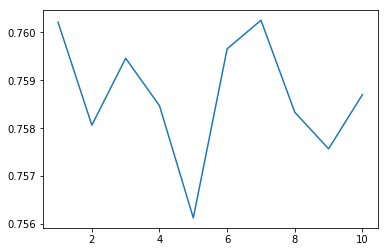

In [105]:
#leaf_nodes
tuning_estimators = {}
for n in list(range(1,11)):
    model.set_params(max_depth=3, n_estimators=20, max_leaf_nodes=n)
    model.train_test_split(test_size=0.33,random_state=10)
    model.fit()
    tuning_estimators[n] = model.evaluate()
eval_df = pd.DataFrame([[k, v] for k, v in tuning_estimators.items()])
eval_df.rename(index=str, columns={0: "max_leaf_nodes", 1: "eval_score"},inplace=True)
pyplot.plot('max_leaf_nodes','eval_score',data=eval_df)

In [106]:
eval_df

,max_leaf_nodes,eval_score
0,1,0.760212
1,2,0.758063
2,3,0.759459
3,4,0.758468
4,5,0.756127
5,6,0.759657
6,7,0.760253
7,8,0.758334
8,9,0.757569
9,10,0.758700


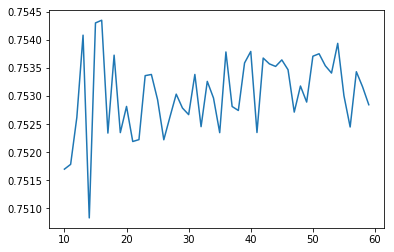

In [107]:
#n_estimators
tuning_estimators = {}
for n in range(10,60):
    model.set_params(max_depth=3, n_estimators=n)
    model.train_test_split(test_size=0.33,random_state=1)
    model.fit()
    tuning_estimators[n] = model.evaluate()
eval_df = pd.DataFrame([[k, v] for k, v in tuning_estimators.items()])
eval_df.rename(index=str, columns={0: "n_estimators", 1: "eval_score"},inplace=True)
pyplot.plot('n_estimators','eval_score',data=eval_df)

# Feature engineering

- Walk distance per kill
- Swim per kill
- relative distances
- damage per kill

In [146]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'num_players',
       'group_size', 'possible_winPlacePerc', 'test_test'],
      dtype='object')

In [152]:
def stat_per_kill(stat,kills):
    if kills == 0:
        return 0
    else:
        return stat/kills

In [158]:
df['kills'].head()

0    0
1    0
2    0
3    0
4    1
Name: kills, dtype: int64

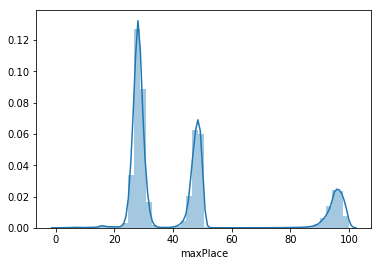

In [162]:
sns.distplot(df.maxPlace)

sns.distplot(df.winPlacePerc,kde=False)

In [218]:
per_kill_vars = {
    'dam_per_kill':'damageDealt',
    'walk_per_kill':'walkDistance',
    'weapons_per_kill':'weaponsAcquired'
}

for k,v in per_kill_vars.items():
    df[k] = df.apply(lambda row: stat_per_kill(row[v],row['kills']),axis=1)

KeyboardInterrupt: 

In [219]:
all_ex_vars.extend(per_kill_vars.keys())

# KILLS BY TEAM

In [ ]:
exogenous_vars = {
    'combat':['kills','assists','heals','DBNOs','weaponsAcquired','vehicleDestroys','damageDealt'],
    'combat_extended':['boosts','killPlace','killPoints','revives'],
    'kill_stats':['headshotKills','killStreaks','roadKills'],
    'distance_metrics':['walkDistance','rideDistance','swimDistance'],
    'game_data':['numGroups','matchDuration','num_players'],
    'team_stats':['group_size'],
    'match_type':['matchType_crashfpp', 'matchType_crashtpp',
       'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp',
       'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp'],
}


In [861]:
def get_kills_by_group(group):
    return np.sum(df[df.groupId == group].kills)

In [862]:
get_kills_by_group('4d4b580de459be')

4

In [ ]:
df['kills_by_group'] = df.groupId.apply(lambda group: np.sum(df[df.groupId == group].kills))

In [ ]:
df.head()

In [ ]:
exogenous_vars = {
    'combat':['kills','assists','heals','DBNOs','weaponsAcquired','vehicleDestroys','damageDealt'],
    'combat_extended':['boosts','killPlace','killPoints','revives'],
    'kill_stats':['headshotKills','killStreaks','roadKills'],
    'distance_metrics':['walkDistance','rideDistance','swimDistance'],
    'game_data':['numGroups','matchDuration','num_players'],
    'team_stats':['group_size','kills_by_group'],
    'match_type':['matchType_crashfpp', 'matchType_crashtpp',
       'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp',
       'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp'],
}

# Model 2

In [752]:
model2 = RFR()
model2.set_x_vars(all_ex_vars)
model2.sample(df,0.03)
model2.set_params(max_depth=20, n_estimators=69,max_leaf_nodes=7)
model2.train_test_split(test_size=0.33,random_state=100)
model2.fit()
model2.evaluate()

explained variance score:  0.9226495470844572
mean absolute error:  0.060087545918514826


In [750]:
# for i in range(10,21):
#     print('new iteration')
#     print('max_depth=',i)
#     model2.set_params(max_depth=i,n_estimators=69,max_leaf_nodes=7)
#     model2.fit()
#     model2.evaluate()
#     print(' ')

In [753]:
# for i in range(21,31):
#     print('new iteration')
#     print('max_depth=',i)
#     model2.set_params(max_depth=i,n_estimators=69,max_leaf_nodes=None)
#     model2.fit()
#     model2.evaluate()
#     print(' ')

In [755]:
model2 = RFR()
model2.set_x_vars(all_ex_vars)
model2.sample(df,0.03)
model2.set_params(max_depth=19, n_estimators=69,max_leaf_nodes=7)
model2.train_test_split(test_size=0.3,random_state=100)
model2.fit()
model2.evaluate()

explained variance score:  0.9216268890566122
mean absolute error:  0.059949410054477056


['kills',
 'assists',
 'heals',
 'DBNOs',
 'weaponsAcquired',
 'vehicleDestroys',
 'damageDealt',
 'boosts',
 'killPlace',
 'killPoints',
 'headshotKills',
 'killStreaks',
 'roadKills',
 'walkDistance',
 'rideDistance',
 'swimDistance',
 'numGroups',
 'matchDuration',
 'num_players',
 'dam_per_kill',
 'walk_per_kill',
 'weapons_per_kill']

# Model 3

In [760]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'num_players',
       'group_size', 'possible_winPlacePerc', 'test_test', 'dam_per_kill',
       'walk_per_kill', 'weapons_per_kill'],
      dtype='object')

In [762]:
df.matchType.unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [764]:
df = pd.get_dummies(df, columns=['matchType'])

In [767]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups',
       'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance',
       'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired',
       'winPoints', 'winPlacePerc', 'num_players', 'group_size',
       'possible_winPlacePerc', 'test_test', 'dam_per_kill', 'walk_per_kill',
       'weapons_per_kill', 'matchType_crashfpp', 'matchType_crashtpp',
       'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp',
       'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp'],
      dtype='object')

In [768]:
match_type_columns = ['matchType_crashfpp', 'matchType_crashtpp',
       'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp',
       'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp']

In [769]:
exogenous_vars = {
    'combat':['kills','assists','heals','DBNOs','weaponsAcquired','vehicleDestroys','damageDealt'],
    'combat_extended':['boosts','killPlace','killPoints','revives'],
    'kill_stats':['headshotKills','killStreaks','roadKills'],
    'distance_metrics':['walkDistance','rideDistance','swimDistance'],
    'game_data':['numGroups','matchDuration','num_players'],
    'team_stats':['group_size'],
    'match_type':['matchType_crashfpp', 'matchType_crashtpp',
       'matchType_duo', 'matchType_duo-fpp', 'matchType_flarefpp',
       'matchType_flaretpp', 'matchType_normal-duo',
       'matchType_normal-duo-fpp', 'matchType_normal-solo',
       'matchType_normal-solo-fpp', 'matchType_normal-squad',
       'matchType_normal-squad-fpp', 'matchType_solo', 'matchType_solo-fpp',
       'matchType_squad', 'matchType_squad-fpp'],
}



In [770]:
all_ex_vars = []
{all_ex_vars.extend(i) for i in exogenous_vars.values()}

{None}

In [772]:
#try tuning max leaf nodes again

In [780]:
model3 = RFR()
model3.set_x_vars(all_ex_vars)
model3.sample(df,0.03)
model3.set_params(max_depth=21, n_estimators=69,max_leaf_nodes=22)
model3.train_test_split(test_size=0.33,random_state=420)
model3.fit()
model3.evaluate()

explained variance score:  0.9240421333693544
mean absolute error:  0.05937650651230588


In [776]:
model3.fix()
model3.evaluate()

explained variance score:  0.9260525545540819
mean absolute error:  0.05879637211048609


In [777]:
for i in range(5,40):
    model3.set_params(max_depth=21, n_estimators=69,max_leaf_nodes=i)
    model3.fit()
    model3.fix()
    print('MLN:', i)
    model3.evaluate()

MLN: 5
explained variance score:  0.926137716757155
mean absolute error:  0.05875845186150557
MLN: 6
explained variance score:  0.9260173578471211
mean absolute error:  0.0588990422130073
MLN: 7
explained variance score:  0.9263052833450174
mean absolute error:  0.05877009548995213
MLN: 8
explained variance score:  0.9260622392771322
mean absolute error:  0.0587317211057283
MLN: 9
explained variance score:  0.9260914364897386
mean absolute error:  0.05878480724807406
MLN: 10
explained variance score:  0.9260353452281779
mean absolute error:  0.05880718479701386
MLN: 11
explained variance score:  0.9259443686702568
mean absolute error:  0.05881948685585762
MLN: 12
explained variance score:  0.9263729738914931
mean absolute error:  0.05867507225282473
MLN: 13
explained variance score:  0.9261839352259179
mean absolute error:  0.058820730399268176
MLN: 14
explained variance score:  0.925944102046697
mean absolute error:  0.058818395262373466
MLN: 15
explained variance score:  0.9260771694

# XGBoost Regression

In [405]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [818]:
# custom loss function
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain
    h = .69  #h is delta
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = -d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [ ]:
class XGBR():
    def __init__(self):
        #leave for future changes
        pass
    
    def set_x_vars(self,var_list):
        #set x variables
        if type(var_list) != list:
            raise TypeError('must be a list')
        self.x_vars = var_list
        
    def add_x_var(self,x_var):
        # add a new x variable
        self.x_vars.append(x_var)
        
    def sample(self,df,frac):
        self.filt_df = df[self.x_vars + ['winPlacePerc']+['possible_winPlacePerc']].dropna().sample(frac=frac)
        self.X = self.filt_df[self.x_vars + ['possible_winPlacePerc']]
        self.y = self.filt_df['winPlacePerc']
    
    def set_params(
        self,
        n_estimators, 
        objective, 
        learning_rate = 0.1, 
        L2 = 1,
        max_leaves=10,
        max_depth=10,
        grow_policy = 'depthwise', 
        gamma=None):
        
        self.regr = XGBRegressor(
            n_estimators = n_estimators,
            objective = objective,
            learning_rate = learning_rate,
            reg_lambda = L2,
            booster="dart",
            max_leaves=max_leaves,
            max_depth = max_depth,
            grow_policy = grow_policy,
            gamma=gamma,
            #DART params
            sample_type='weighted',
            normalize_type='tree',
            rate_drop=0.1,
            #skip_drop=0.5,
            #
            tree_method = 'approx'
        )
    
    def train_test_split(self,test_size=0.33,random_state=2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
    
    def fit(self,eval_metric = 'mae'):
        self.fit_ = self.regr.fit(
            self.X_train[self.x_vars], self.y_train,
            eval_set=[(self.X_train[self.x_vars], self.y_train), (self.X_test[self.x_vars], self.y_test)],
            eval_metric = eval_metric
        )
        
    def predict(self):
        self.y_pred = self.fit_.predict(self.X_test[self.x_vars])
    def evaluate(self):
        print('explained variance score: ', explained_variance_score(self.y_test, self.y_pred))
        print('mean absolute error: ', mean_absolute_error(self.y_test,self.y_pred))
    def nudge(self):
        for i,y in enumerate(self.y_pred):
            if y < 0:
                self.y_pred[i] = 0
            elif y > 1:
                self.y_pred[i] = 1

---

In [853]:
xmodel = XGBR()
xmodel.set_x_vars(all_ex_vars)
xmodel.sample(df,0.03)

In [855]:
xmodel.set_params(
    grow_policy = 'depthwise',
    n_estimators = 300,
    max_leaves=1000,
    max_depth=25,
    gamma = 0.03,
    objective = huber_approx_obj,
    learning_rate = 0.5,
    L2 = 0.9)
xmodel.train_test_split(test_size = 0.1, random_state = 420)
xmodel.fit(eval_metric='mae')

[15:11:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-mae:0.118547	validation_1-mae:0.120191
[1]	validation_0-mae:0.078728	validation_1-mae:0.082343
[2]	validation_0-mae:0.063327	validation_1-mae:0.067771
[3]	validation_0-mae:0.057699	validation_1-mae:0.063284
[4]	validation_0-mae:0.055502	validation_1-mae:0.061934
[5]	validation_0-mae:0.055502	validation_1-mae:0.061519
[6]	validation_0-mae:0.056413	validation_1-mae:0.110796
[7]	validation_0-mae:0.05506	validation_1-mae:0.060887
[8]	validation_0-mae:0.050848	validation_1-mae:0.060724
[9]	validation_0-mae:0.07442	validation_1-mae:0.082797
[10]	validation_0-mae:0.050705	validation_1-mae:0.060734
[11]	validation_0-mae:0.121502	validation_1-mae:0.060584
[12]	validation_0-mae:0.049572	validation_1-mae:0.061448
[13]	validation_0-mae:0.049496	validation_1-mae:0.074946
[14]	validation_0-mae:0.050794	validation_1-mae:0.075206
[15]	validation_0-mae:0.051358	validation_1-mae:0.060546
[1

KeyboardInterrupt: 

In [847]:
xmodel.predict()
xmodel.nudge()
xmodel.evaluate()

explained variance score:  0.9182105832111354
mean absolute error:  0.06131595771128463


---
### Best Bootstrap Aggregated Random Forest Regression
- explained variance score:  0.9262453478988742
- mean absolute error:  0.05878365867236959
---
---
### Need to grid search max_depth, max_leaves, gamma, and L2 penalty
---
---

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.2,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [732]:
# for l2_penalty in range(11,21):
#     xmodel.set_params(n_estimators = 10, objective = huber_approx_obj, learning_rate = 1.3, L2 = l2_penalty)
#     xmodel.train_test_split(test_size = 0.1, random_state = 420)
#     xmodel.fit(eval_metric='mae')
#     print(l2_penalty)
#     xmodel.predict()
#     xmodel.evaluate()

In [789]:
xmodel.predict()
xmodel.evaluate()

explained variance score:  0.788920194549177
mean absolute error:  0.09730261271263793


In [790]:
xmodel.nudge()
xmodel.evaluate()

explained variance score:  0.8032010546136089
mean absolute error:  0.09416676250399003


---
## BEST Random Forest Regression
- explained variance score:  0.9262453478988742
- mean absolute error:  0.05878365867236959
---

- reg_alpha
- reg_lambda
- scale_pos_weight

In [373]:
help(xmodel.fit_)

Help on XGBRegressor in module xgboost.sklearn object:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective

In [476]:
help(XGBRegressor.fit)

Help on function fit in module xgboost.sklearn:

fit(self, X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None)
    Fit the gradient boosting model
    
    Parameters
    ----------
    X : array_like
        Feature matrix
    y : array_like
        Labels
    sample_weight : array_like
        instance weights
    eval_set : list, optional
        A list of (X, y) tuple pairs to use as a validation set for
        early-stopping
    sample_weight_eval_set : list, optional
        A list of the form [L_1, L_2, ..., L_n], where each L_i is a list of
        instance weights on the i-th validation set.
    eval_metric : str, callable, optional
        If a str, should be a built-in evaluation metric to use. See
        doc/parameter.rst. If callable, a custom evaluation metric. The call
        signature is func(y_predicted, y_true) where y_true will be a
        DMatrix object 

In [ ]:
xmodel.evaluate()

In [243]:
help(XGBRegressor(objective=mean_absolute_error))

Help on XGBRegressor in module xgboost.sklearn object:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective

In [756]:
sample_submission.head()

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1


In [757]:
test_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [ ]:
# ENJINEER DA FEECHIZ
player_count = Counter(df['matchId'])
df['num_players'] = df['matchId'].apply(lambda mid: player_count[mid])

group_count = Counter(df['groupId'])
df['group_size'] = df['groupId'].apply(lambda gid: group_count[gid])



In [758]:
sample_submission.head()

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1
